<a href="https://colab.research.google.com/github/NeonLabs146/General_stuffs/blob/main/Sales_Estimate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install pmdarima
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 27.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm


import matplotlib.pyplot as plt
from IPython import get_ipython
from IPython.display import display
from statsmodels.tsa.stattools import adfuller
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
from pmdarima import auto_arima

In [ ]:
df = pd.read_csv('KiranaPasal_Data.csv', index_col='Date', parse_dates=True)

In [ ]:
df.info() , df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 730 entries, 2081-01-01 to 2082-12-31
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Sales               730 non-null    int64  
 1   Festival_Indicator  730 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 17.1 KB


(None,
             Sales  Festival_Indicator
 Date                                 
 2081-01-01  23904                 0.0
 2081-01-02  31138                 0.0
 2081-01-03  19682                 0.0
 2081-01-04  20632                 0.0
 2081-01-05  18692                 0.0)

**Check for Stationarity**

**The SARIMAX model assumes that the time series is stationary. If the data is not stationary, the model may produce unreliable results. Use the Augmented Dickey-Fuller (ADF) test to check for stationarity:**

In [ ]:
from statsmodels.tsa.stattools import adfuller

# Perform ADF test
result = adfuller(df['Sales'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -11.71429363286165
p-value: 1.4637535944274574e-21


If the p-value > 0.05, the series is non-stationary. Apply differencing (d and D in SARIMAX) to make it stationary.

####**Tuning Sarimax Parameters**

1. Grid Search

* Very Slow approach

In [ ]:
from joblib import Parallel, delayed
import warnings
warnings.filterwarnings("ignore")  # Suppress warnings

# Split data (80% Train, 20% Test)
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Define parameter ranges (Reduce search space for speed)
p = d = q = range(0, 3)
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in itertools.product(p, d, q)]

# Function to train and evaluate model
def evaluate_sarimax(order, seasonal_order):
    try:
        model = SARIMAX(train['Sales'].values,
                        exog=train[['Festival_Indicator']].values,
                        order=order,
                        seasonal_order=seasonal_order,
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        results = model.fit(disp=0)
        return order, seasonal_order, results.aic
    except:
        return order, seasonal_order, np.inf  # Assign high AIC to failed models

# Run grid search in parallel
results = Parallel(n_jobs=-1)(delayed(evaluate_sarimax)(param, seasonal_param)
                               for param in itertools.product(p, d, q)
                               for seasonal_param in seasonal_pdq)

# Find best parameters
best_order, best_seasonal_order, best_aic = min(results, key=lambda x: x[2])

print(f'Best SARIMAX Order: {best_order}')
print(f'Best Seasonal Order: {best_seasonal_order}')
print(f'Best AIC: {best_aic}')


Best SARIMAX Order: (0, 0, 0)
Best Seasonal Order: (2, 2, 2, 12)
Best AIC: 10945.744567735823


* Best SARIMAX Order: (0, 0, 0)
* Best Seasonal Order: (2, 2, 2, 12)
* Best AIC: 10945.744567735823

In [ ]:

# Split data (80% Train, 20% Test)
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

In [ ]:
#2. Automatically find the best SARIMAX parameters
model = auto_arima(train['Sales'],
                   exogenous=train[['Festival_Indicator']],
                   seasonal=True,
                   m=12,
                   trace=True,
                   error_action='ignore',
                   suppress_warnings=True,
                   stepwise=True)

print(model.summary())

# Re-fit the model without insignificant terms
model = SARIMAX(train['Sales'],
                exog=train[['Festival_Indicator']],
                order=(0, 0, 0),  # Remove AR term
                seasonal_order=(2, 2, 2, 12),  # Remove seasonal AR term
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit(disp=False)
print(results.summary())

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=11939.727, Time=5.57 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=11940.360, Time=0.03 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=11911.561, Time=0.96 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=11917.215, Time=1.15 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=13549.825, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=11910.174, Time=0.06 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=11911.170, Time=0.99 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=1.56 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=11904.941, Time=0.11 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=11906.522, Time=0.93 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=11906.357, Time=0.39 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=11908.351, Time=1.55 sec
 ARIMA(3,0,0)(0,0,0)[12] intercept   : AIC=11901.063, Time=0.16 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(1,0,0)[12] intercept   : AIC=11902.518, Time=1.28 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(0,0,1)[12] intercept   : AIC=11902.377, Time=0.48 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(1,0,1)[12] intercept   : AIC=11904.372, Time=2.28 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,0)(0,0,0)[12] intercept   : AIC=11897.764, Time=0.21 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,0)(1,0,0)[12] intercept   : AIC=11899.145, Time=2.33 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,0)(0,0,1)[12] intercept   : AIC=11898.993, Time=1.43 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,0)(1,0,1)[12] intercept   : AIC=11900.989, Time=2.28 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,0)(0,0,0)[12] intercept   : AIC=11899.004, Time=0.27 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,1)(0,0,0)[12] intercept   : AIC=11899.710, Time=0.28 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(0,0,0)[12] intercept   : AIC=11902.810, Time=0.23 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,1)(0,0,0)[12] intercept   : AIC=11900.987, Time=0.47 sec
 ARIMA(4,0,0)(0,0,0)[12]             : AIC=inf, Time=0.07 sec

Best model:  ARIMA(4,0,0)(0,0,0)[12] intercept
Total fit time: 25.153 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  584
Model:               SARIMAX(4, 0, 0)   Log Likelihood               -5942.882
Date:                Fri, 28 Feb 2025   AIC                          11897.764
Time:                        07:59:06   BIC                          11923.984
Sample:                    01-01-2081   HQIC                         11907.983
                         - 08-07-2082                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
i

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                   SARIMAX Results                                   
Dep. Variable:                         Sales   No. Observations:                  584
Model:             SARIMAX(2, 2, [1, 2], 12)   Log Likelihood               -5466.872
Date:                       Fri, 28 Feb 2025   AIC                          10945.745
Time:                               07:59:10   BIC                          10971.438
Sample:                           01-01-2081   HQIC                         10955.797
                                - 08-07-2082                                         
Covariance Type:                         opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Festival_Indicator  2.124e+04    971.123     21.875      0.000    1.93e+04    2.31e+04
ar.S.L12              -0.4629      0.148     -3.120

In [ ]:
# Define SARIMAX model (simple order, will tune later)
model = SARIMAX(train['Sales'],
                exog=train[['Festival_Indicator']],
                order=(0, 0, 0),
                seasonal_order=(2, 2, 2, 12),
                enforce_stationarity=False,
                enforce_invertibility=False)

# Fit the model
sarimax_model = model.fit(disp=False)

# Summary of the model
sarimax_model.summary()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                   SARIMAX Results                                   
=====================================================================================
Dep. Variable:                         Sales   No. Observations:                  584
Model:             SARIMAX(2, 2, [1, 2], 12)   Log Likelihood               -5466.872
Date:                       Fri, 28 Feb 2025   AIC                          10945.745
Time:                               08:24:37   BIC                          10971.438
Sample:                           01-01-2081   HQIC                         10955.797
                                - 08-07-2082                                         
Covariance Type:                         opg                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Festival_Indicator  2.124e+04    971.123     21.875      0.000    1.93e+04    2.31e+04
ar.S.L12              -0.4629      0.148     -3.120      0.002      -0.754      -0.172
ar.S.L24              -0.2353      0.090     -2.604      0.009      -0.412      -0.058
ma.S.L12              -1.1182      0.148     -7.555      0.000      -1.408      -0.828
ma.S.L24               0.1864      0.139      1.346      0.178      -0.085       0.458
sigma2              4.727e+07      0.076    6.2e+08      0.000    4.73e+07    4.73e+07
===================================================================================
Ljung-Box (L1) (Q):                   1.02   Jarque-Bera (JB):                 2.00
Prob(Q):                              0.31   Prob(JB):                         0.37
Heteroskedasticity (H):               0.74   Skew:                            -0.14
Prob(H) (two-sided):                  0.04   Kurtosis:                         3.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.48e+23. Standard errors may be unstable.
"""

In [ ]:
!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 4.4 MB/s eta 0:00:00


In [ ]:
#Bayesian Optimization (More Efficient than Grid Search)
from skopt import gp_minimize
from skopt.space import Integer
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define SARIMAX evaluation function
def sarimax_objective(params):
    p, d, q, P, D, Q = params
    try:
        model = SARIMAX(train['Sales'],
                        exog=train[['Festival_Indicator']],
                        order=(p, d, q),
                        seasonal_order=(P, D, Q, 12),
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        results = model.fit(disp=0)
        return results.aic
    except:
        return np.inf  # Assign a high AIC for failed models

# Define search space
search_space = [
    Integer(0, 2, name="p"),
    Integer(0, 2, name="d"),
    Integer(0, 2, name="q"),
    Integer(0, 2, name="P"),
    Integer(0, 2, name="D"),
    Integer(0, 2, name="Q"),
]

# Run Bayesian Optimization
res = gp_minimize(sarimax_objective, search_space, n_calls=20, random_state=42)

best_params = res.x
print(f"Best SARIMAX Order: {(best_params[0], best_params[1], best_params[2])}")
print(f"Best Seasonal Order: {(best_params[3], best_params[4], best_params[5], 12)}")

Best SARIMAX Order: (0, 0, 0)
Best Seasonal Order: (1, 1, 2, 12)


In [ ]:
# Define the SARIMA model
data = df['Sales']
model = sm.tsa.SARIMAX(data, order=(1, 1, 1), seasonal_order=(1, 1, 2, 12))

In [ ]:
# Fit the model
sarima_fit = model.fit(disp=0)
# Print summary of the model
print(sarima_fit.summary())

# Make predictions
predictions = sarimax_model.predict(start=test.index[0], end=test.index[-1], exog=test[['Festival_Indicator']], dynamic=False)


                                   SARIMAX Results                                   
Dep. Variable:                         Sales   No. Observations:                  584
Model:             SARIMAX(2, 2, [1, 2], 12)   Log Likelihood               -5466.872
Date:                       Fri, 28 Feb 2025   AIC                          10945.745
Time:                               08:25:07   BIC                          10971.438
Sample:                           01-01-2081   HQIC                         10955.797
                                - 08-07-2082                                         
Covariance Type:                         opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Festival_Indicator  2.124e+04    971.123     21.875      0.000    1.93e+04    2.31e+04
ar.S.L12              -0.4629      0.148     -3.120

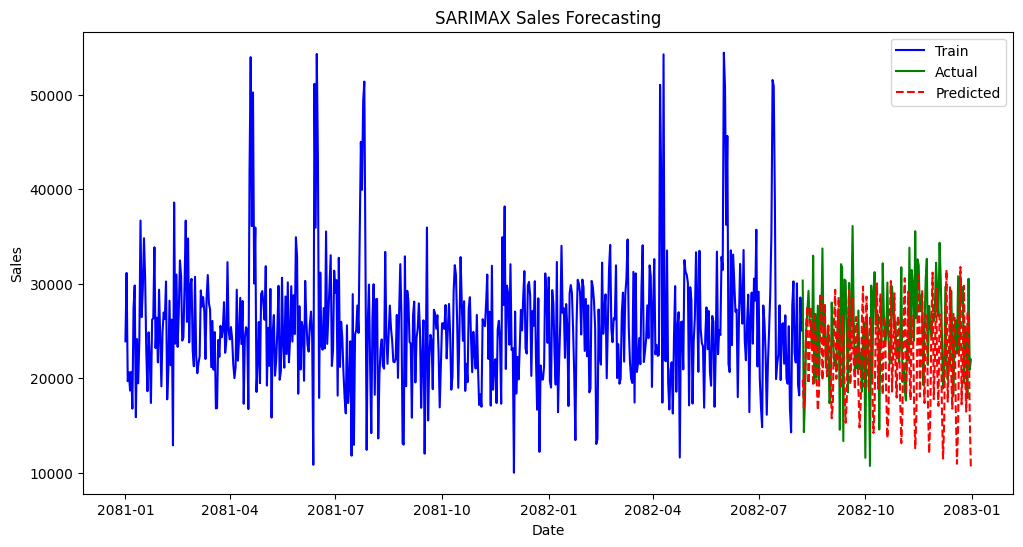

In [ ]:
# Plot actual vs predicted sales
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Sales'], label='Train', color='blue')
plt.plot(test.index, test['Sales'], label='Actual', color='green')
plt.plot(test.index, predictions, label='Predicted', color='red', linestyle='dashed')
plt.legend()
plt.title("SARIMAX Sales Forecasting")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()

In [ ]:
# Make predictions
predictions = sarimax_model.predict(
    start=test.index[0],
    end=test.index[-1],
    exog=test[['Festival_Indicator']],
    dynamic=False
)

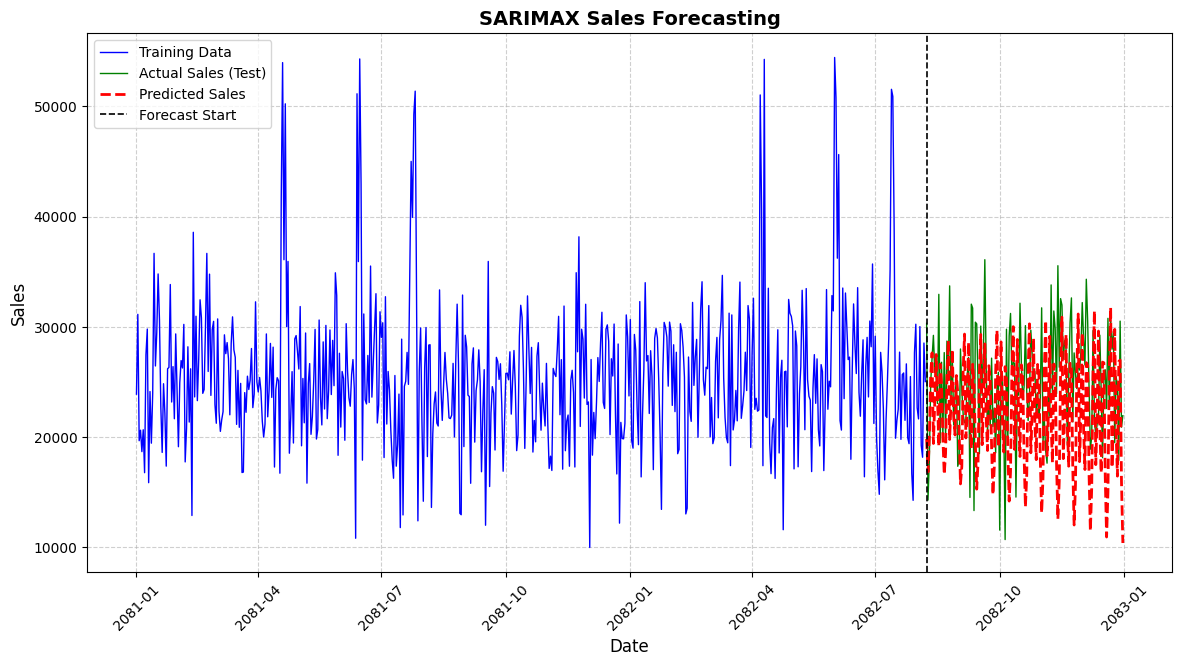

In [ ]:
# Create figure
plt.figure(figsize=(14, 7))

# Plot training data
plt.plot(train.index, train['Sales'], label='Training Data', color='blue', linewidth=1)

# Plot actual test data
plt.plot(test.index, test['Sales'], label='Actual Sales (Test)', color='green', linewidth=1)

# Plot predicted data
plt.plot(test.index, predictions, label='Predicted Sales', color='red', linestyle='dashed', linewidth=2)

# Add vertical line to mark transition from training to testing
plt.axvline(x=test.index[0], color='black', linestyle='--', linewidth=1.2, label="Forecast Start")

# Titles and labels
plt.title("SARIMAX Sales Forecasting", fontsize=14, fontweight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Sales", fontsize=12)
plt.xticks(rotation=45)  # Rotate dates for better readability
plt.legend(loc='upper left', fontsize=10)  # Move legend for clarity
plt.grid(True, linestyle='--', alpha=0.6)  # Add grid for better visualization

# Show plot
plt.show()

In [ ]:
# Apply smoothing for better visualization
train_smooth = train['Sales'].rolling(window=7).mean()
test_smooth = test['Sales'].rolling(window=7).mean()
pred_smooth = predictions.rolling(window=7).mean()

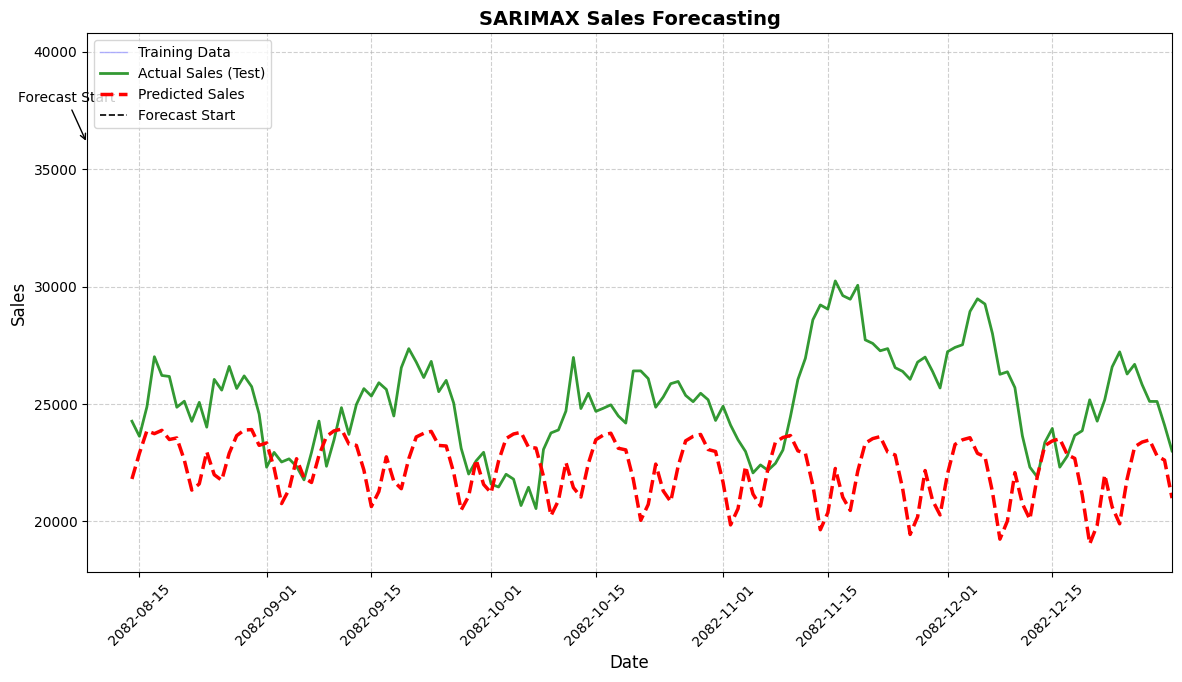

In [ ]:
# Create figure
plt.figure(figsize=(14, 7))

# Plot training data (faded)
plt.plot(train.index, train_smooth, label='Training Data', color='blue', alpha=0.3, linewidth=1)

# Plot actual test data (bold)
plt.plot(test.index, test_smooth, label='Actual Sales (Test)', color='green', alpha=0.8, linewidth=2)

# Plot predicted data (bold & dashed)
plt.plot(test.index, pred_smooth, label='Predicted Sales', color='red', linestyle='dashed', linewidth=2.5)

# Add confidence interval if available
# plt.fill_between(test.index, lower_bound, upper_bound, color='red', alpha=0.2, label='Prediction Interval')

# Add vertical line to mark transition from training to testing
plt.axvline(x=test.index[0], color='black', linestyle='--', linewidth=1.2, label="Forecast Start")

# Annotate forecast start
plt.annotate("Forecast Start", xy=(test.index[0], test['Sales'].max()),
             xytext=(-50, 30), textcoords='offset points',
             arrowprops=dict(arrowstyle="->", color='black'))

# Titles and labels
plt.title("SARIMAX Sales Forecasting", fontsize=14, fontweight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Sales", fontsize=12)
plt.xticks(rotation=45)  # Rotate dates for better readability
plt.legend(loc='upper left', fontsize=10)  # Move legend for clarity
plt.grid(True, linestyle='--', alpha=0.6)  # Add grid for better visualization

# Zoom in on forecast period
plt.xlim(test.index[0], test.index[-1])

# Show plot
plt.show()

**Address Insignificant Coefficients**

The current model has insignificant coefficients for ar.L1 and ar.S.L12 (p-values > 0.05). This suggests that these terms may not be necessary.

* Remove the insignificant terms by setting their orders to 0.
* Re-fit the model with updated orders.